# Initial Setup

- import various helpers, load data, select reviews by status and category

In [2]:
import sys
sys.path.append('../')

from application.name_obj_classes import PubName, PersonName, remove_punct

from application.review_obj_class import ReviewObj

from application.text_preprocessing import preprocess_text

import os
import pandas as pd
import re
from collections import Counter
import numpy as np
import pickle
from nltk.metrics import edit_distance
%pprint

Pretty printing has been turned OFF


In [3]:
from database import *
import database.models as models

# load full text from db
aps_details_single = models.Review().query.filter(models.Review.status.in_(('needs_crosscheck', 'done'))).filter(models.Review.review_type == 'single_focus').all()

len(aps_details_single)

561

In [4]:
titles = [i.reviewed_book_title for i in aps_details_single]
titles[:5]

['Missouri', 'The Confessions of Lord Byron', 'Carnival', 'Photographic Illustrations of Cutaneous Syphilis', 'Life and Letters of Dante Gabriel Rossetti']

In [5]:
reviews_parsed = [ReviewObj(i.record_id, i.full_text) for i in aps_details_single]
#reviews_parsed[0].cleaned_text
reviews_parsed[0].cleaned_toks[:10]

['Missouri', ':', 'A', 'Bone', 'of', 'Contention', "'", 'WE', 'aware', 'that']

In [6]:
import string
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

def remove_function_tail(sequence):
    if sequence[-1].lower() in stopwords.words('english'):
        sequence.pop()
        return remove_function_tail(sequence)
    else:
        return sequence

In [7]:
all_candidates_tidy = []
for one_review in reviews_parsed:
    title_candidates = [list(),]
    for token in one_review.cleaned_toks:
        if token.istitle() or token in stopwords.words('english') or token in string.punctuation:
            if len(title_candidates[-1]) > 0:
                if token not in string.punctuation:
                    title_candidates[-1].append(token)
            else:
                if token.istitle():
                    title_candidates[-1].append(token)
        else:
            if len(title_candidates[-1]) > 0:
                title_candidates.append(list())
    
    candidates_tidy = []
    for sequence in title_candidates:
        # rule out if all function words
        all_function = True
        for word in sequence:
            if word.lower() not in stopwords.words('english'):
                all_function = False
                break
        if all_function == False:
            #remove function word tails recursively
            sequence = remove_function_tail(sequence)
            candidates_tidy.append(sequence)
    all_candidates_tidy.append(candidates_tidy) 

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
all_scores = []

# loop all_candidates_tidy
for e,t in enumerate(all_candidates_tidy):
    # true label is titles[e]
    # get headline text
    block_one = aps_details_single[e].record_title
    text_blocks = []
    for i in t:
        text_blocks.extend(i)
    text_merged = [block_one + " " + " ".join(text_blocks),]    
    
    # this title is comparison_set[-1]
    comparison_set = titles + text_merged
    
    # compare 
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(comparison_set)
    vectors = X.toarray()
    # loop all, get similarity, last one is always 1.0
    scores = []
    for v in vectors:
        score = cosine_similarity([v], [vectors[-1]])
        scores.append(score)
    all_scores.append(scores)

In [10]:
# how often is the right answer the top answer? how often is the correct match in the top 5?
output = []
for e, score_grid in enumerate(all_scores):
    df = pd.DataFrame()
    df['score'] = [i[0][0] for i in score_grid][:-1]
    df['title'] = titles
    match = []
    for i in range(len(titles)):
        if e == i:
            match.append('yes')
        else:
            match.append('no')
    df['match'] = match
    output.append(df.sort_values(by="score", ascending=False).reset_index(drop=False))

In [11]:
top_match = []
top_five = []
top_ten = []
top_25 = []
for i in output:
    df_five = i.iloc[:5]
    df_ten = i.iloc[:10]
    df_25 = i.iloc[:25]
    top_match.append(i.iloc[0]['match'] == 'yes')
    top_five.append(len(df_five.loc[df_five['match'] == 'yes']) > 0)
    top_ten.append(len(df_ten.loc[df_ten['match'] == 'yes']) > 0)
    top_25.append(len(df_25.loc[df_25['match'] == 'yes']) > 0)

In [15]:
# 50% correct without headline; 55.25% with
len([i for i in top_match if i])/len(top_match)
# 62%; 65.59%
len([i for i in top_five if i])/len(top_five)
# 65%; 68.98
len([i for i in top_ten if i])/len(top_ten)
#69%; 73.44
#len([i for i in top_25 if i])/
len(top_25)

561

In [16]:
top_n = []
accuracy = []

for r in range(1, 562):
    results = []
    for i in output:
        df_n = i.iloc[:r]
        # check if 'yes' is in df_n
        result = len(df_n.loc[df_n['match'] == 'yes']) > 0
        results.append(result)
    acc = len([i for i in results if i])/len(results) 
    top_n.append(r)
    accuracy.append(acc)

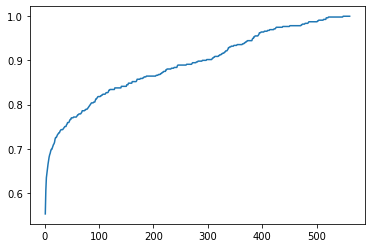

In [17]:
%matplotlib inline
import seaborn as sns
sns.lineplot(x=top_n, y=accuracy)

In [ ]:
results_audit = []
for i in output:
    df = i.loc[i['match'] == 'yes']
    results_audit.append(df)
# results_audit[10]
# this title was 214th out of len(titles)
df = pd.concat(results_audit).reset_index(drop=False)
df = df.rename(columns={"index": "original_index", "level_0": "rank"})
df.loc[df['rank'] == 0]

In [ ]:
import numpy as np
#all_candidates_tidy[18]
# top score is low
# top 5 are basicaly tied

variances = []
top_score = []
for i in output:
    top_score.append(i.iloc[0]['score'])
    v = np.var(list(i.iloc[:5]['score']))
    variances.append(v)
df['top_5_variance'] = variances
df['top_score'] = top_score
when_confident = list(df.loc[df['top_score'] > .40]['rank'])
len([i for i in when_confident if i == 0])/len(when_confident), len(when_confident)

In [ ]:
%matplotlib inline
import seaborn as sns
x = []
y = []
#graph accuracy as relates to confidence cutoffs
for val in range(1, 100, 1):
    c = val/100
    when_confident = list(df.loc[df['top_score'] > c]['rank'])
    try:
        acc = len([i for i in when_confident if i == 0])/len(when_confident)
        x.append(c)
        y.append(acc)
    except:
        pass
sns.lineplot(x,y)

In [ ]:
when_high_variance = list(df.loc[df['top_5_variance'] > .0009]['rank'])
len([i for i in when_high_variance if i == 0])/len(when_high_variance ), len(when_high_variance )

In [ ]:
x = []
y = []
#graph accuracy as relates to confidence cutoffs
for val in range(10, 150, 2):
    c = val/100000
    when_high_variance = list(df.loc[df['top_5_variance'] > c]['rank'])
    
    try:
        acc = len([i for i in when_high_variance  if i == 0])/len(when_high_variance )
        x.append(c)
        y.append(acc)
    except:
        pass
sns.lineplot(x,y)

In [ ]:
# how correlated are they? 
np.corrcoef(df['top_5_variance'], df['top_score'])

In [ ]:
# train a regression on these two variables
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

# labels and matrix
labels = [0 if i == 0 else 1 for i  in list(df['rank'])]
len([i for i in labels if i == 0])/len(labels)

In [ ]:
#len(labels), len(list(df['top_5_variance'])), len(list(df['top_score']))
Z = list(zip(list(df['top_5_variance']), list(df['top_score'].to_numpy())))
# instantiate the model and fit to the training data

lr = LogisticRegression()
scores = cross_val_score(lr, Z, labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#62-65% is not very accurate ... these don't predict well enough

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight={0:.48, 1:.52})
scores = cross_val_score(clf, Z, labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#72% is a little better ... and significantly better than 55%

## Remarks 

None of these methods is very helpful. The problem is that very few title matches have high confidences. Most likely, the underlying test just isn't doing what I hoped. 

- Maybe combine fuzziness with vectors ... using either fuzzy clustering or word embeddings? Or doc2vec?
- Maybe take out very common words from the candidates
- TFIDF?


In [ ]:
import json, nltk
from gensim.models import Word2Vec
#from gensim.models import KeyedVectors

words = []
title_tokens = []
for i in titles:
    tokens = word_tokenize(i.lower())
    title_tokens.append(tokens)
    words.extend(tokens)
words = list(set(words))

data = [[x.lower() for x in word_tokenize(i.full_text)] for i in aps_details_single] + title_tokens

In [ ]:
model = Word2Vec(sentences=data, size=300, window=4, min_count=1, workers=8, sg=1)

In [ ]:
len(words)

In [ ]:
replacements = {}
for w in words:
    if len(w) > 1:
        matches = model.wv.most_similar(w)
        for m in matches:
            if m[0] not in words:
                if nltk.edit_distance(w,m[0]) < 1 and m[1] > 0.85:
                    try:
                        replacements[w].append(m[0])
                    except:                        
                        replacements[w] = [m[0],]

In [ ]:
replacements

In [ ]:
title_tokens[1]

In [ ]:
[i.lower() for i in word_tokenize(aps_details_single[1].full_text)]

In [ ]:
#replace typos with common ocr list